# Bayesian meta-analysis of two proportions in random control trials (RCTs)
---

This notebook shows how to perform a specific type of meta-analysis in Python/PyMC. The example is adapted from John Kruschke, who originally implemented this analysis in R. Here are links to his [blog entry](http://doingbayesiandataanalysis.blogspot.com/2016/11/bayesian-meta-analysis-of-two.html) and [article](https://link.springer.com/article/10.3758/s13423-016-1221-4).

In this example, we are interested in the number of deaths ("occurrences of mortality") from heart attack in a control group and a treatment group that were "treated" with beta-blockers (a class of drugs that relaxes heart muscles). Let $z_T$ denote the number of occurrences in the treatment group, $n_T$ denote the total number of participants in the treatment group, and $z_C$ and $n_C$ denote the same for the controls. If beta-blockers have a beneficial effect, then $z_T/n_T$ should be less than $z_C/n_C$. 

In a meta-analysis, we are combining information (data) from several studies examining the same phenomenon in order to make better inferences. The data from study $s$ are denoted $z_{C[s]}$, $n_{C[s]}$, etc. The key insight is that even though we don't expect the proportions of occurrences to be the identical across different studies/sites, as each site has its own attributes, we do expect the studies to be similar and mutually informative. That is, we expect Study A to tell us something about Study B, and vice versa. This means we should treat the data from different sites as representative of higher-level parameters that describe what is typical across sites and how much variability there is across sites. This approach is referred to as a **random-effects model**. Here are the equations for this model, starting with the likelihoods in the first two lines:

$$z_C \sim \text{Binomial}(\theta_{C[s]}, n_{C[s]})$$
$$z_T \sim \text{Binomial}(\theta_{T[s]}, n_{T[s]})$$
$$\theta_{C[s]} \sim \text{Beta}(\omega_{\theta C})$$
$$\theta_{T[s]} = \text{logistic}(\rho_s + \text{logit}(\theta_{C[s]}))$$
$$\rho_{s} \sim \text{Normal}(\mu_{\rho}, \sigma_{\rho}^2)$$
$$\mu_{\rho} \sim \text{Normal}(0, 100)$$
$$\sigma_{\rho} \sim \text{Gamma}(\alpha=1.64, \beta=0.64)$$

Here, $\rho_s$ is the difference of log-odds between groups, or, the *log odds ratio* across groups: $\rho_s = \text{log}([\theta_{T[s]}/(1 - \theta_{T[s]})]/[\theta_{C[s]}/(1 - \theta_{C[s]})]$. The distribution across $\rho_s$ is described by a normal distribution, parameterized by its mean and SD. Therefore, what we are most interested in is $\mu_{\rho}$, the estimated treatement effect across studies. ***Check out the links I've provided for more details.*** 

The data we will model are from 22 studies, involving anywhere between 77 and 3,887 patients. The are described in Gelamn et al.'s *Bayesian Data Analysis, Third Edition*. The treatment group received beta-blockers. If the treatment is effective, the log odds ratio will be less than zero. 

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt

# Import meta-analysis module of bayes-toolbox
import bayes_toolbox.meta as bm

In [2]:
%config InlineBackend.figure_format = 'retina'
# az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95
rng = np.random.default_rng(seed=42)

In [3]:
# Data from 22 studies
# fmt: off
z_t_obs = [
    3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22
]
n_t_obs = [
    38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251,
    151, 174, 209, 391, 680
]
z_c_obs = [
    3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43,
    39
]
n_c_obs = [
    39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 
    154, 134, 218, 364, 674
]
# fmt: on

# We will "name" each study to provide study labels to parameters
# in our summary plots
N = len(n_c_obs)
study = []
for x in range(N):
    study.append("study" + str(x + 1))

# Create dataframe
df = pd.DataFrame(
    {
        "z_t_obs": z_t_obs,
        "n_t_obs": n_t_obs,
        "z_c_obs": z_c_obs,
        "n_c_obs": n_c_obs,
        "study": study,
    }
)

In [4]:
model, idata = bm.meta_binary_outcome(
    z_t_obs, n_t_obs, z_c_obs, n_c_obs, study, n_draws=2000
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_rho, sigma_rho, omega_theta_c, kappa_minus_two_theta_c, rho, theta_c]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.


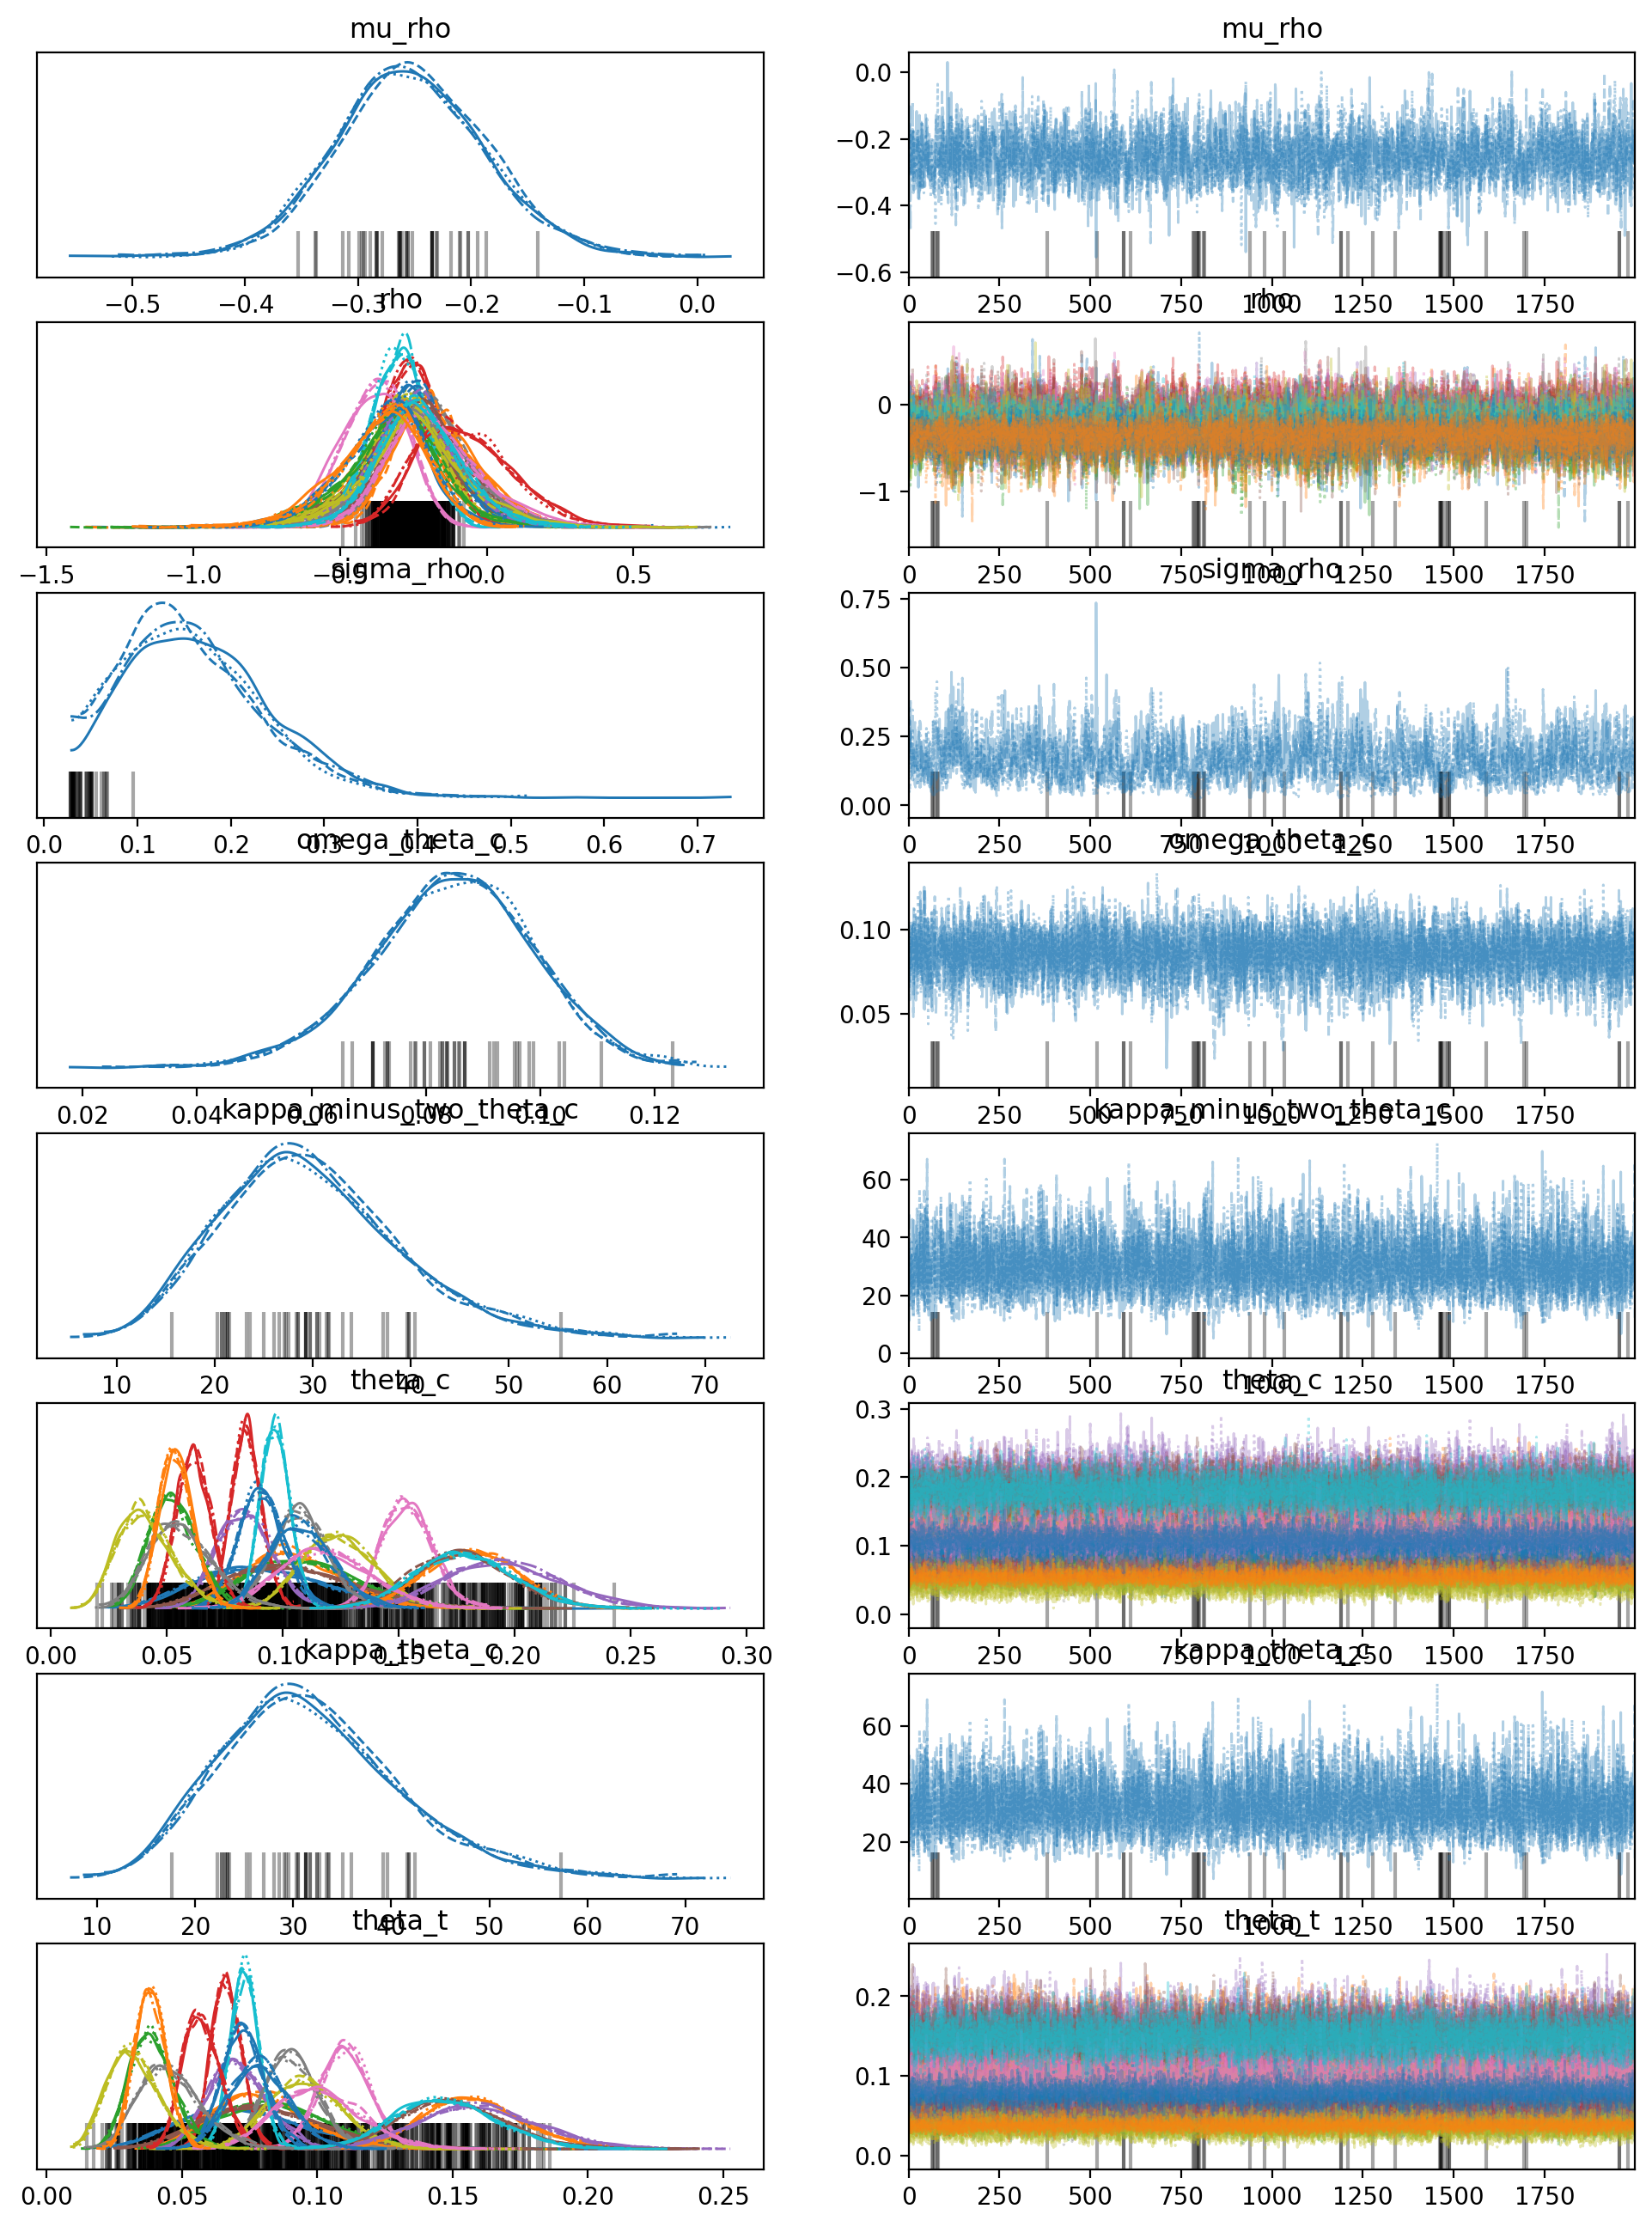

In [5]:
az.plot_trace(idata);

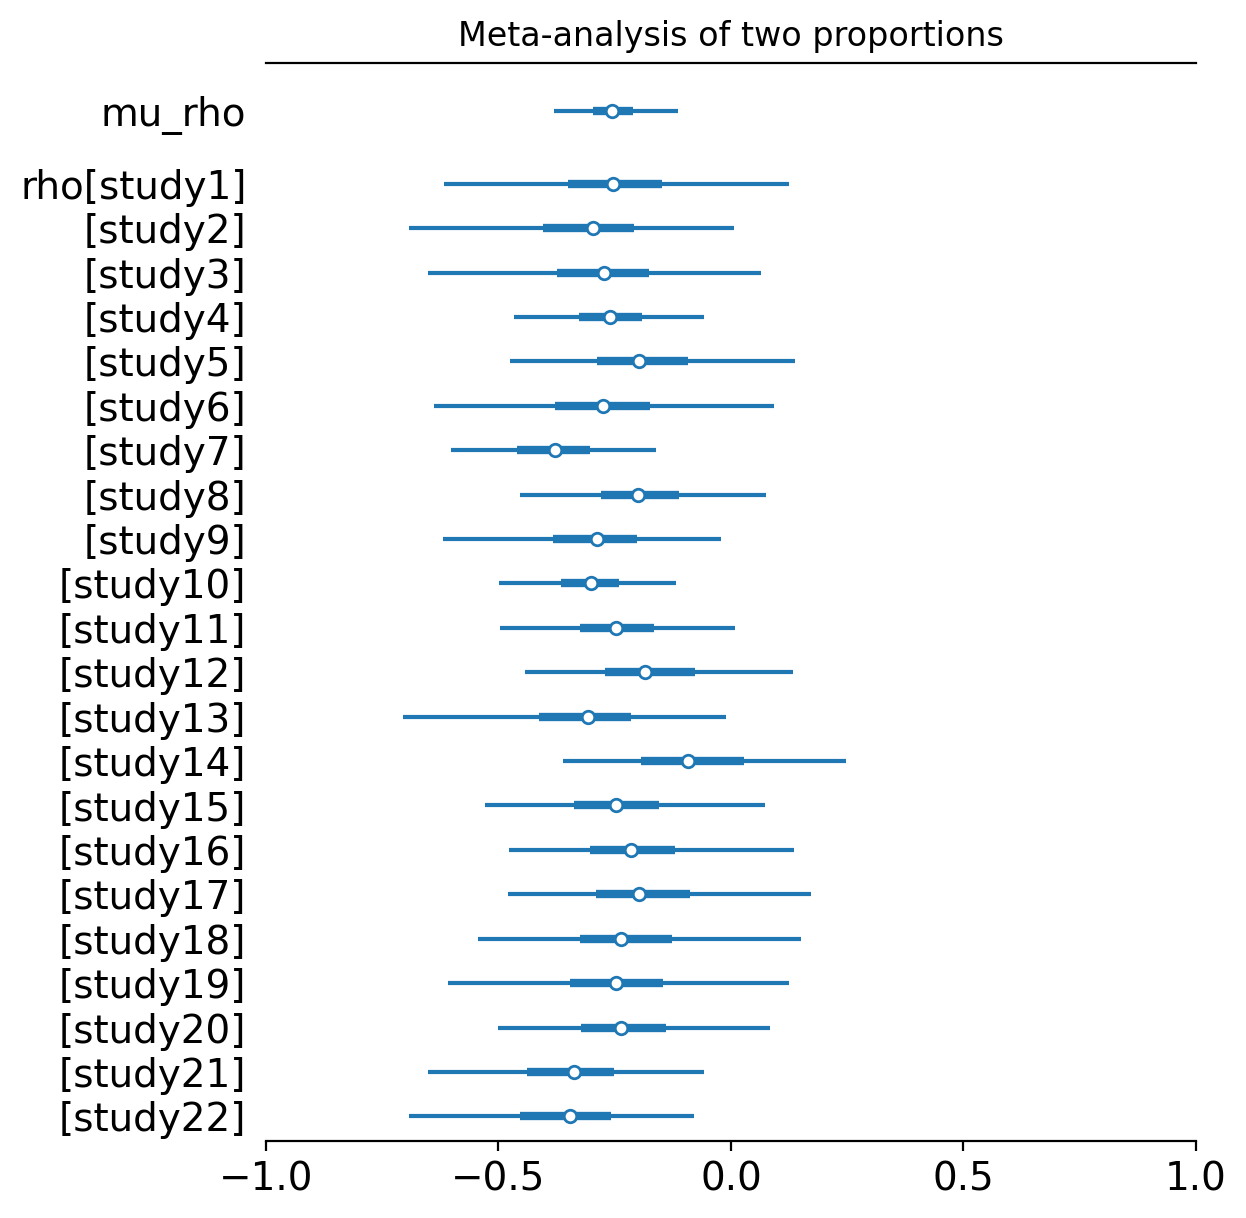

In [6]:
_, ax = plt.subplots(figsize=(6, 7))
az.plot_forest(
    idata, var_names=["mu_rho", "rho"], kind="forestplot", combined=True, ax=ax
)
ax.set_xlim([-1, 1])
ax.set_title("Meta-analysis of two proportions");

In [7]:
az.summary(idata, var_names=["mu_rho", "rho"])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_rho,-0.254,0.067,-0.380,-0.115,0.001,0.001,2765.0,4327.0,1.0
rho[study1],-0.248,0.182,-0.617,0.125,0.002,0.002,6637.0,4522.0,1.0
rho[study2],-0.313,0.170,-0.692,0.007,0.002,0.002,5541.0,3692.0,1.0
rho[study3],-0.279,0.174,-0.651,0.065,0.002,0.002,6520.0,5120.0,1.0
rho[study4],-0.259,0.103,-0.467,-0.058,0.001,0.001,5856.0,6175.0,1.0
rho[study5],-0.185,0.155,-0.476,0.137,0.002,0.002,4374.0,5018.0,1.0
rho[study6],-0.278,0.180,-0.639,0.092,0.002,0.002,6067.0,4414.0,1.0
rho[study7],-0.384,0.115,-0.602,-0.162,0.002,0.002,2430.0,4435.0,1.0
rho[study8],-0.192,0.133,-0.454,0.075,0.002,0.001,4172.0,5047.0,1.0
rho[study9],-0.296,0.147,-0.619,-0.022,0.002,0.002,5938.0,4480.0,1.0


The estimated parameter values above are highly consistent with those reported in the Kruschke analysis using R and JAGS.